In [75]:
!git clone https://github.com/ultralytics/yolov5.git



fatal: destination path 'yolov5' already exists and is not an empty directory.


In [2]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip /content/drive/MyDrive/person_car/data_train.zip -d /content/drive/MyDrive/person_car

In [76]:
import os
import json
from tqdm import tqdm
import shutil


In [4]:

def make_folders(path="output"):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

def convert_bbox_coco2yolo(img_width, img_height, bbox):
    """
    Convert bounding box from COCO  format to YOLO format

    Parameters
    ----------
    img_width : int
        width of image
    img_height : int
        height of image
    bbox : list[int]
        bounding box annotation in COCO format: 
        [top left x position, top left y position, width, height]

    Returns
    -------
    list[float]
        bounding box annotation in YOLO format: 
        [x_center_rel, y_center_rel, width_rel, height_rel]
    """
    
    # YOLO bounding box format: [x_center, y_center, width, height]
    # (float values relative to width and height of image)
    x_tl, y_tl, w, h = bbox

    dw = 1.0 / img_width
    dh = 1.0 / img_height

    x_center = x_tl + w / 2.0
    y_center = y_tl + h / 2.0

    x = x_center * dw
    y = y_center * dh
    w = w * dw
    h = h * dh

    return [x, y, w, h]
  
def convert_coco_json_to_yolo_txt(output_path, json_file):

    path = make_folders(output_path)

    with open(json_file) as f:
        json_data = json.load(f)

    # write _darknet.labels, which holds names of all classes (one class per line)
    label_file = os.path.join(output_path, "_darknet.labels")
    with open(label_file, "w") as f:
        for category in tqdm(json_data["categories"], desc="Categories"):
            category_name = category["name"]
            f.write(f"{category_name}\n")

    for image in tqdm(json_data["images"], desc="Annotation txt for each iamge"):
        img_id = image["id"]
        img_name = image["file_name"]
        img_width = image["width"]
        img_height = image["height"]

        anno_in_image = [anno for anno in json_data["annotations"] if anno["image_id"] == img_id]
        anno_txt = os.path.join(output_path, img_name.split(".")[0] + ".txt")
        with open(anno_txt, "w") as f:
            for anno in anno_in_image:
                category = anno["category_id"] -1 
                bbox_COCO = anno["bbox"]
                x, y, w, h = convert_bbox_coco2yolo(img_width, img_height, bbox_COCO)
                f.write(f"{category} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

    print("Converting COCO Json to YOLO txt finished!")

In [9]:
convert_coco_json_to_yolo_txt("/content/drive/MyDrive/person_car/data_train/all_labels/", "/content/drive/MyDrive/person_car/data_train/annotation_json/bbox-annotations.json")

Annotation txt for each iamge: 100%|██████████| 2239/2239 [00:28<00:00, 79.43it/s]


Converting COCO Json to YOLO txt finished!


In [12]:
#moving labels of train/val into their respective folders.
def move_files(source_img_dir, source_label_dir, target_label_dir):
  for each_img in os.listdir(source_img_dir):
    # print(each_img)
    txt_name = each_img.split(".")[0]+ ".txt"
    source_file = os.path.join(source_label_dir, txt_name)
    target_file = os.path.join(target_label_dir, txt_name)
    print(txt_name)
    shutil.copy(source_file, target_file)


In [ ]:

ALL_LABELS = "/content/drive/MyDrive/person_car/data_train/all_labels/"
TRAIN_DIR = "/content/drive/MyDrive/person_car/data_train/train"
VAL_DIR = "/content/drive/MyDrive/person_car/data_train/val"

train_imgs = os.path.join(TRAIN_DIR, "images")
val_imgs = os.path.join(VAL_DIR, "images")  

train_label_dir = os.path.join(TRAIN_DIR, "labels")
val_label_dir = os.path.join(VAL_DIR, "labels")
if not os.path.exists(train_label_dir):
  os.mkdir(os.path.join(TRAIN_DIR, "labels"))
if not os.path.exists(val_label_dir):
  os.mkdir(os.path.join(VAL_DIR, "labels"))



move_files(train_imgs, ALL_LABELS, train_label_dir)
move_files(val_imgs, ALL_LABELS, val_label_dir)



In [77]:
!ls /content/drive/MyDrive/person_car/data_train/val/labels | wc -l

239


In [78]:
#creating a yaml for training 
import yaml
data = dict(
    names = ['person', 'car'],
    nc = 2,
    path= "/content/drive/MyDrive/person_car/data_train/",
    train="/content/drive/MyDrive/person_car/data_train/train/images",
    val="/content/drive/MyDrive/person_car/data_train/val/images"

)

with open('/content/yolov5/custom.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

In [79]:
!python3 /content/yolov5/train.py --img 416 --batch 8 --epochs 10 --data /content/yolov5/custom.yaml --weights yolov5l.pt

train: weights=yolov5l.pt, cfg=, data=/content/yolov5/custom.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=8, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-234-gd490bdd Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, h

In [66]:
#Test the model
weights_path = "/content/drive/MyDrive/person_car/data_train/weights/best.pt"
import torch
from PIL import Image
import numpy as np
import cv2
import json

In [86]:




thresh_conf = 0.25

# model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=False, classes=2)
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path)

img = Image.open('/content/drive/MyDrive/person_car/data_train/val/images/image_000002222.jpg')
results = model(img, size=416)

print(f'prediction: {results.pred}')
df = json.loads(results.pandas().xyxy[0].to_json(orient="records"))

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-5-29 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 290 layers, 20856975 parameters, 0 gradients
Adding AutoShape... 


prediction: [tensor([[2.53110e+01, 8.35916e+01, 9.22984e+02, 6.15646e+02, 8.87787e-01, 1.00000e+00],
        [5.65837e+02, 2.03698e+01, 7.45264e+02, 1.87507e+02, 7.42679e-01, 0.00000e+00],
        [3.80017e+02, 9.08070e+01, 5.30707e+02, 1.37204e+02, 5.94319e-01, 1.00000e+00]], device='cuda:0')]


In [87]:
print(df)


[{'xmin': 25.3109607697, 'ymin': 83.5915908813, 'xmax': 922.9839477539, 'ymax': 615.646484375, 'confidence': 0.8877866268, 'class': 1, 'name': 'car'}, {'xmin': 565.8369140625, 'ymin': 20.369846344, 'xmax': 745.264465332, 'ymax': 187.5073699951, 'confidence': 0.7426792383, 'class': 0, 'name': 'person'}, {'xmin': 380.0170898438, 'ymin': 90.8069534302, 'xmax': 530.7071533203, 'ymax': 137.2038269043, 'confidence': 0.5943191648, 'class': 1, 'name': 'car'}]


In [88]:

cv_img = np.array(img)
for each_d in df:
  print(each_d)
  xmin = int(each_d['xmin'])
  ymin = int(each_d['ymin'])
  xmax = int(each_d['xmax'])
  ymax = int(each_d['ymax'])
  conf = each_d['confidence']
  cls_name = each_d['name']
  if conf > thresh_conf:
    out_img = cv2.rectangle(cv_img, (xmin,ymin), (xmax, ymax), (255,0,0), 2)
    out_img = cv2.putText(out_img, cls_name, (xmin+10, ymin- 10), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (0,0,255), 2, cv2.LINE_AA)


{'xmin': 25.3109607697, 'ymin': 83.5915908813, 'xmax': 922.9839477539, 'ymax': 615.646484375, 'confidence': 0.8877866268, 'class': 1, 'name': 'car'}
{'xmin': 565.8369140625, 'ymin': 20.369846344, 'xmax': 745.264465332, 'ymax': 187.5073699951, 'confidence': 0.7426792383, 'class': 0, 'name': 'person'}
{'xmin': 380.0170898438, 'ymin': 90.8069534302, 'xmax': 530.7071533203, 'ymax': 137.2038269043, 'confidence': 0.5943191648, 'class': 1, 'name': 'car'}


In [64]:
cv2.imwrite("/content/yolov5/out.jpg", out_img)

True

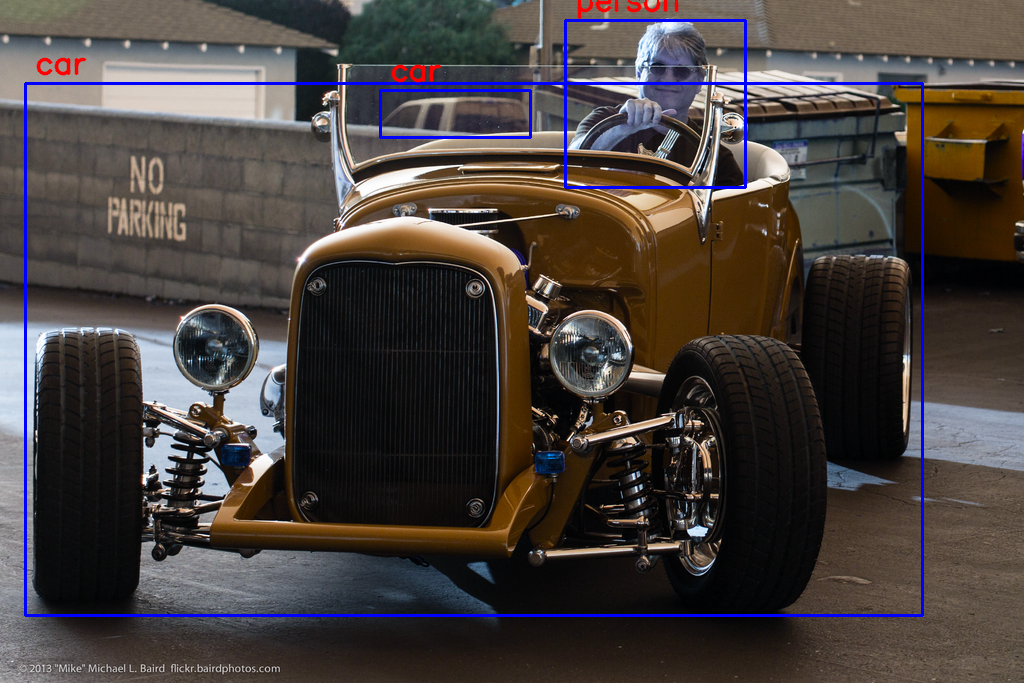

In [89]:
from google.colab.patches import cv2_imshow
cv2_imshow(out_img)